<a href="https://colab.research.google.com/github/IsaacMartindeDiego/IA/blob/master/Reconocimiento_de_d%C3%ADgitos_escritos_a_mano.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Reconocimiento de dígitos escritos a mano**


Para demostrar los principios que fundamentan todo proyecto de Machine Learning, consideremos una parte del problema del reconocimiento óptico de caracteres: la identificación de dígitos escritos a mano. En la naturaleza, este problema implica tanto la localización como la identificación de caracteres en una imagen. Aquí tomaremos un atajo y utilizaremos el conjunto de dígitos preformateados de Scikit-Learn, que está incorporado en la biblioteca.


In this assignment we're going to use information like a person's age, sex, BMI, no. of children and smoking habit to predict the price of yearly medical bills. This kind of model is useful for insurance companies to determine the yearly insurance premium for a person. The dataset for this problem is taken from: https://www.kaggle.com/mirichoi0218/insurance

We will create a model with the following steps:

    Download and explore the dataset
    Prepare the dataset for training
    Create a linear regression model
    Train the model to fit the data
    Make predictions using the trained model

This assignment builds upon the concepts from the first 2 lectures. It will help to review these Jupyter notebooks:

**Carga y visualización de los datos de los dígitos**

Em priner lugar, utilizaremos la interfaz de acceso a datos de Scikit-Learn y echaremos un vistazo a los datos:

In [1]:
from sklearn.datasets import load_digits
digits = load_digits()
digits.images.shape

(1797, 8, 8)

Los datos de las imágenes son una matriz tridimensional: 1.797 muestras, cada una de ellas formada por una cuadrícula de 8 × 8 píxeles.
Visualicemos los cien primeros datos en la bases de datos:

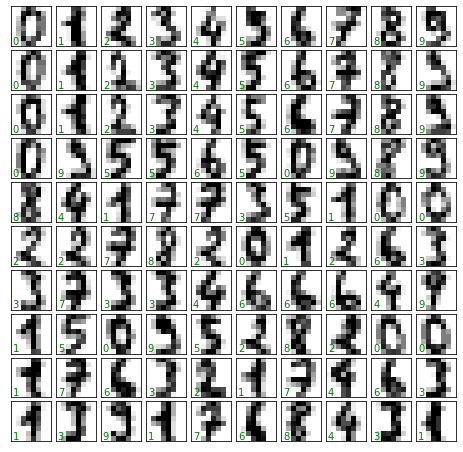

In [2]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(10, 10, figsize=(8, 8),
                         subplot_kw={'xticks':[], 'yticks':[]},
                         gridspec_kw=dict(hspace=0.1, wspace=0.1))

for i, ax in enumerate(axes.flat):
    ax.imshow(digits.images[i], cmap='binary', interpolation='nearest')
    ax.text(0.05, 0.05, str(digits.target[i]),
            transform=ax.transAxes, color='green')